In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [2]:
# read whole year data
allFiles = glob.glob("data/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)

df.columns = map(str.lower, df.columns)

In [3]:
selected_features = ['marketing code','suburb', 'state','post code','enquired',
                     'loan amount','loan_reason','property_use']
target = 'enquiry status';
whole_set = selected_features + [target]

df = df[whole_set]
# df = df.replace('On Hold','Rejected')
# convert loan amount to number type, and change string to NaN
df['loan amount'] = pd.to_numeric(df['loan amount'],errors='coerce')

In [4]:
print("Shape of data frame: {}".format(df.shape))
print("Keys of enquiries_dataset: \n{}".format(df.keys()))
print("data ytpes of enquiries_dataset: \n{}".format(df.dtypes))

Shape of data frame: (48026, 9)
Keys of enquiries_dataset: 
Index(['marketing code', 'suburb', 'state', 'post code', 'enquired',
       'loan amount', 'loan_reason', 'property_use', 'enquiry status'],
      dtype='object')
data ytpes of enquiries_dataset: 
marketing code     object
suburb             object
state              object
post code         float64
enquired           object
loan amount       float64
loan_reason        object
property_use       object
enquiry status     object
dtype: object


In [5]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:marketing code == 22
The number of null values in:suburb == 12422
The number of null values in:state == 12369
The number of null values in:post code == 4283
The number of null values in:enquired == 0
The number of null values in:loan amount == 600
The number of null values in:loan_reason == 9354
The number of null values in:property_use == 9375
The number of null values in:enquiry status == 0


In [6]:
# set all null loan amount to mean valu
df['loan amount'] = df['loan amount'].fillna(df['loan amount'].mean())
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:marketing code == 22
The number of null values in:suburb == 12422
The number of null values in:state == 12369
The number of null values in:post code == 4283
The number of null values in:enquired == 0
The number of null values in:loan amount == 0
The number of null values in:loan_reason == 9354
The number of null values in:property_use == 9375
The number of null values in:enquiry status == 0


In [7]:
df = df.dropna(axis=0, how='any')
df = df[~df[target].isin(['In Progress','Just Received','On Hold'])]

In [8]:
df[target].value_counts()

Rejected    26508
Accepted     4989
Name: enquiry status, dtype: int64

In [9]:
def changeDateType(df): 
    df['enquired'] = pd.DatetimeIndex(df['enquired'])
    df['loan amount'] = df['loan amount'].astype(int)
    df['post code'] = df['post code'].astype(int)
    return df

df = changeDateType(df)
print("data ytpes of enquiries_dataset: \n{}".format(df.dtypes))

data ytpes of enquiries_dataset: 
marketing code            object
suburb                    object
state                     object
post code                  int64
enquired          datetime64[ns]
loan amount                int64
loan_reason               object
property_use              object
enquiry status            object
dtype: object


In [10]:
from datetime import datetime
from dateutil.parser import parse

# filter years
start_date = '2017-01-01' 
end_date = '2017-12-31'
mask = (df['enquired'] > start_date) & (df['enquired'] <= end_date)
df = df.loc[mask].reset_index(drop=True)

def getDetailDate(df):
    # remove Year feature since it is not important (show below random forest)
    # data_set['Year'] = data_set['Enquired'].dt.year
    df['month'] = df['enquired'].dt.month
    df['day'] = df['enquired'].dt.day
    df['hour'] = df['enquired'].dt.hour
    df['weekday'] = df['enquired'].dt.weekday_name

    if("enquired" in df.columns):
        df = df.loc[:,df.columns != 'enquired']
    return df
    
df = getDetailDate(df)

In [11]:
df.columns = df.columns.str.replace('_', ' ')

In [12]:
print("data ytpes of enquiries_dataset: \n{}".format(df.dtypes))

data ytpes of enquiries_dataset: 
marketing code    object
suburb            object
state             object
post code          int64
loan amount        int64
loan reason       object
property use      object
enquiry status    object
month              int64
day                int64
hour               int64
weekday           object
dtype: object


In [13]:
from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col].astype(str))
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

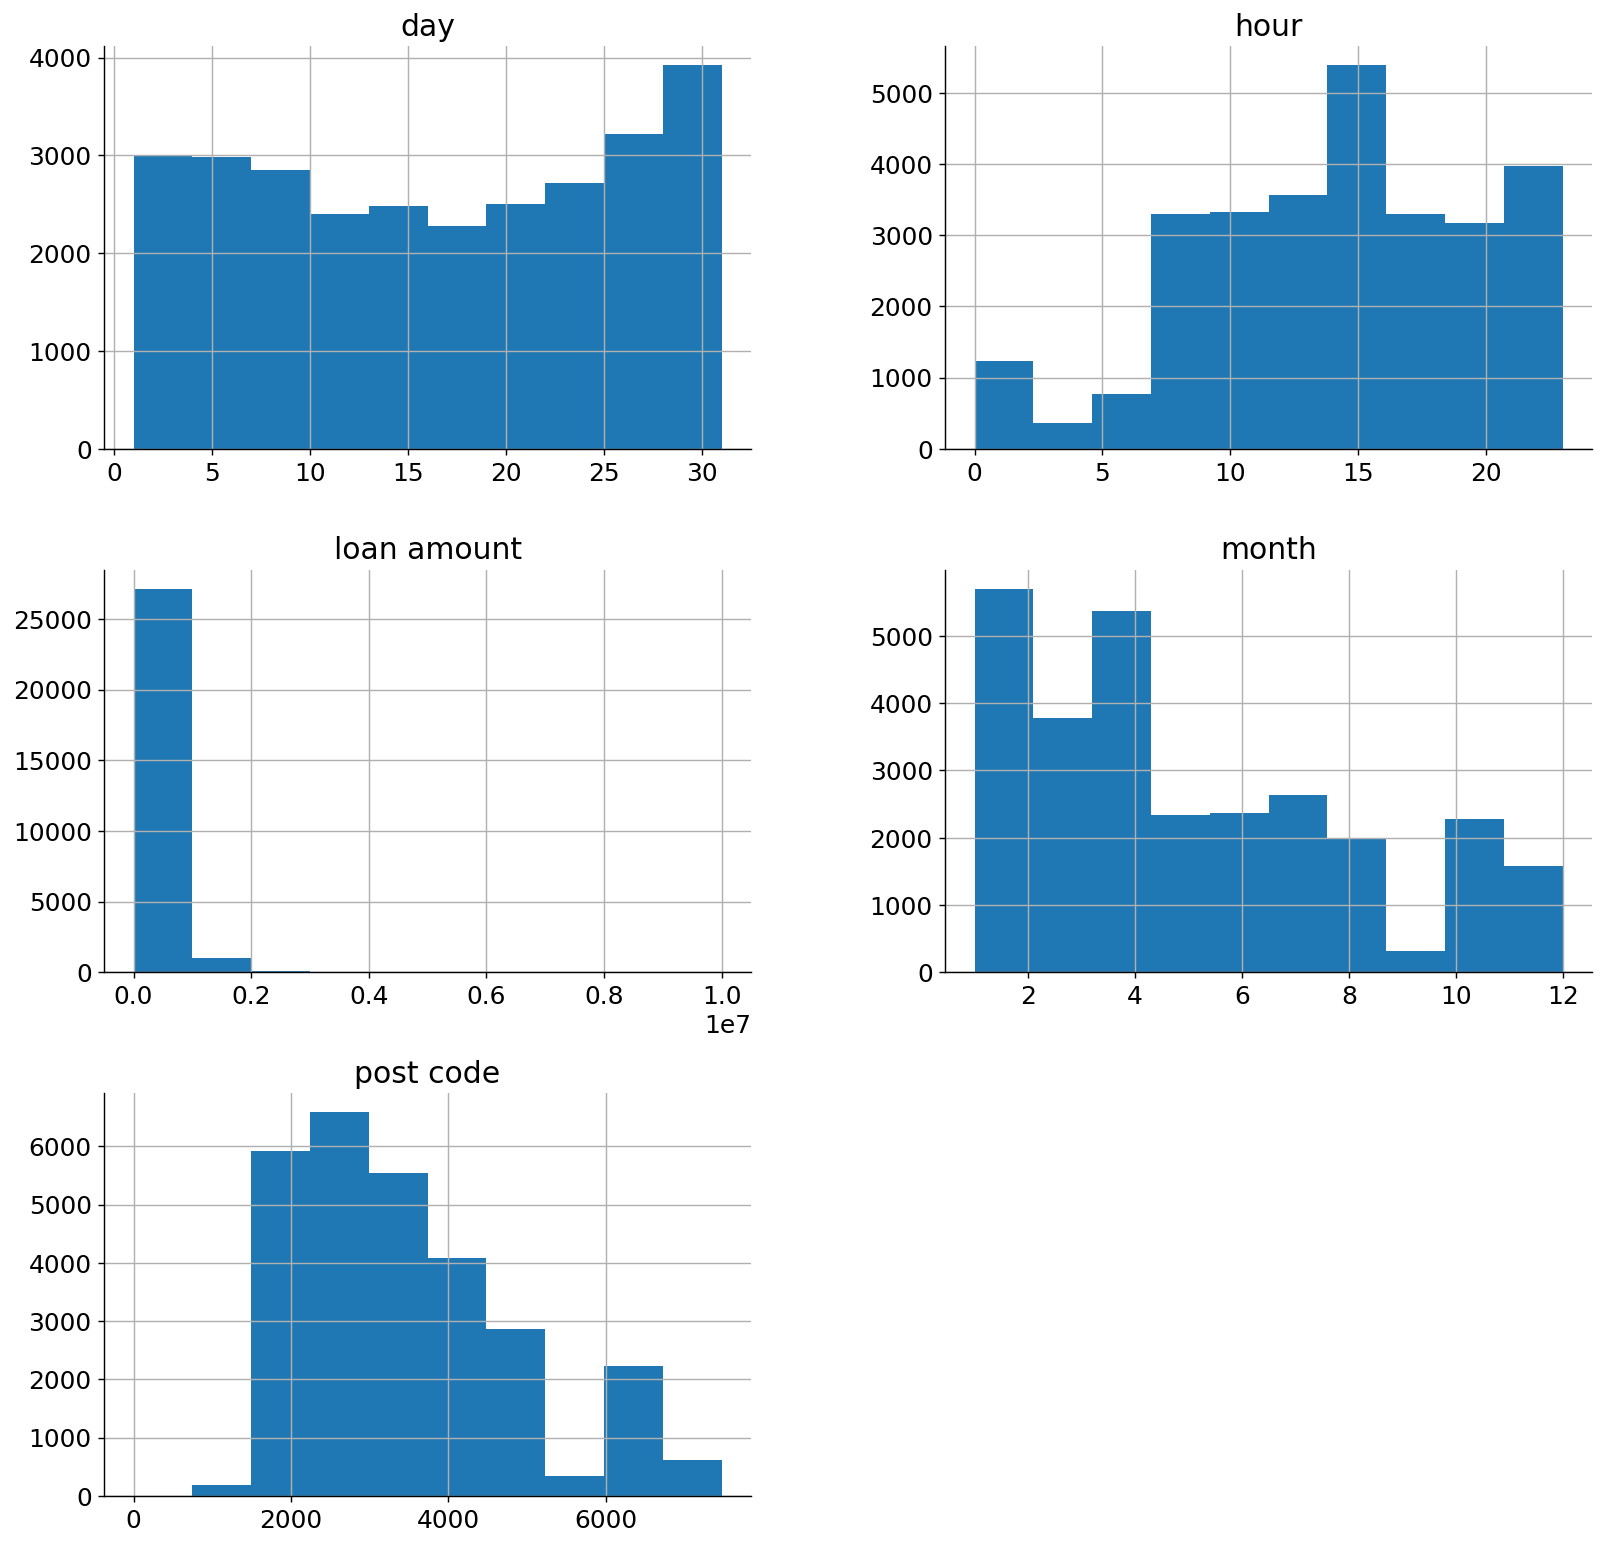

In [14]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# le = LabelEncoder()
# label_df = df.apply(le.fit_transform)
pd.DataFrame.hist(df, figsize = [15,15]);

In [15]:
# X = label_df[df.keys()]
# X = label_df.loc[:,df.columns != target]
# y = label_df[target]
# df = MultiColumnLabelEncoder(columns = df.select_dtypes(include='object')).fit_transform(df)

In [16]:
X = df[df.keys()]
X = df.loc[:,df.columns != target]
y = df[target]

In [17]:
category_column = X.select_dtypes(include='object')

In [18]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class PreProcessing(BaseEstimator, TransformerMixin):
#     """Custom Pre-Processing estimator for our use-case
#     """

#     def __init__(self):
#         pass

#     def transform(self, df):
 
#         return df.as_matrix()

#     def fit(self, df, y=None, **fit_params):
#         return self

In [19]:
X = MultiColumnLabelEncoder(columns = category_column.columns).fit_transform(X)

In [20]:
from sklearn.model_selection import train_test_split

# split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                     test_size=0.4,
                     random_state=0,
                     stratify=y)

In [21]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import KernelPCA
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# N = range(1, 9)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test)
#     print("X_n_kept {}".format(X_n_kept.shape))
#     # Estimate accuracy on the data set with top n components
#     classifier = RandomForestClassifier(n_estimators=10,random_state=1)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))
# # need 7 components

In [22]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import KernelPCA
# from sklearn import svm
# from sklearn.model_selection import cross_val_score

# N = range(1, 9)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test)
#     print("X_n_kept {}".format(X_n_kept.shape))
#     # Estimate accuracy on the data set with top n components
#     classifier = svm.SVC(kernel='rbf')
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

In [23]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import KernelPCA
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score

# N = range(1, 9)
# for n in N:
#     pca = KernelPCA(n_components=n)
#     X_n_kept = pca.fit_transform(X_test)
#     print("X_n_kept {}".format(X_n_kept.shape))
#     # Estimate accuracy on the data set with top n components
#     classifier = LogisticRegression(penalty='l2',C=0.1,random_state=1)
#     score_n_components = cross_val_score(classifier, X_n_kept, y_test).mean()
#     print('Score with the data set of top {0} components: {1:.2f}'.format(n, score_n_components))

In [24]:
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import learning_curve

pipe_lr = make_pipeline(MultiColumnLabelEncoder(columns = category_column.columns),StandardScaler(),KernelPCA(n_components=3),LogisticRegression(penalty='l2',C=0.1,random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/mluo/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Test Accuracy: 0.842


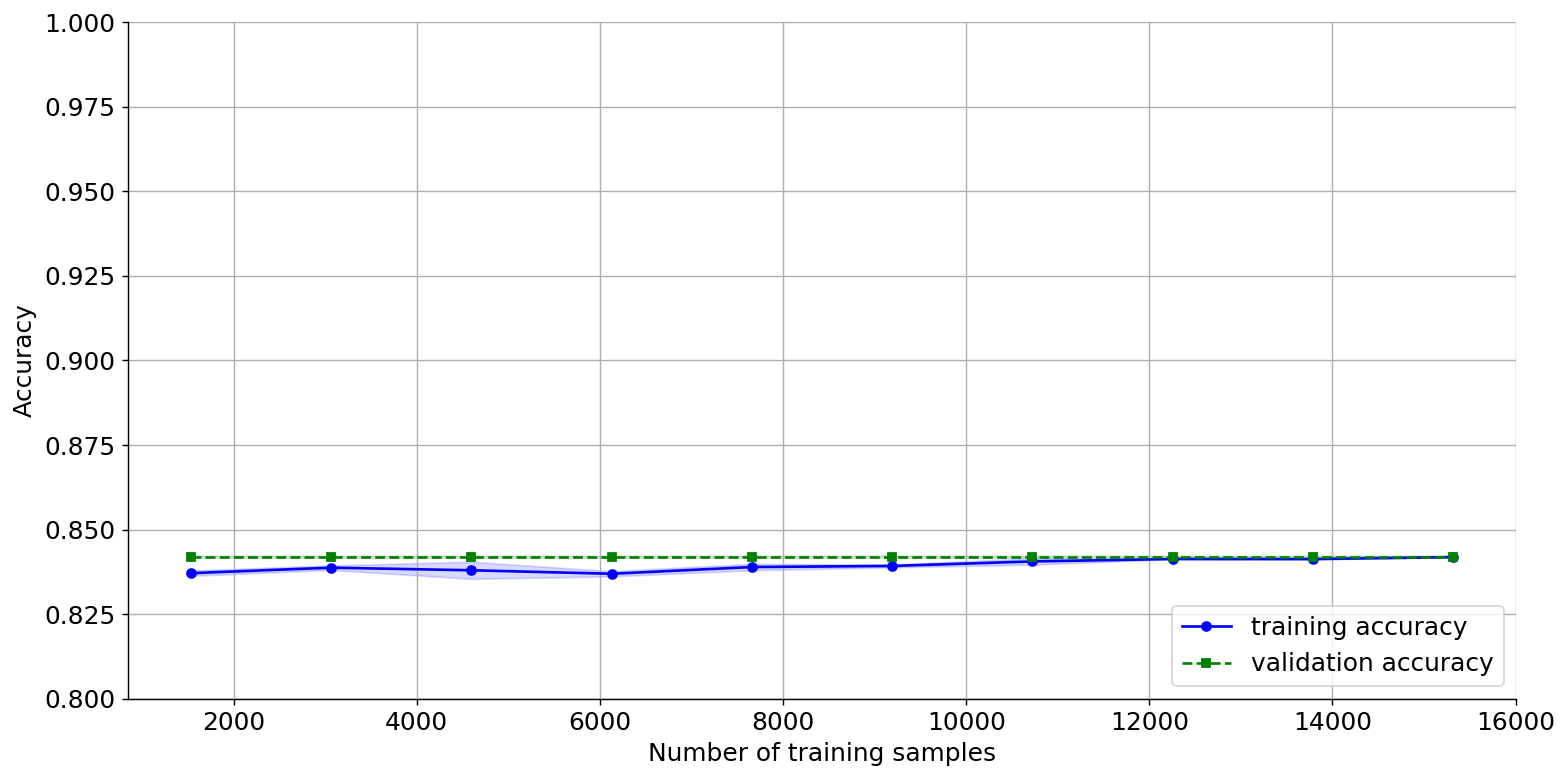

In [25]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [26]:
from sklearn import svm

pipe_svm = make_pipeline(MultiColumnLabelEncoder(columns = category_column.columns),
                         StandardScaler(),
                         KernelPCA(n_components=3),
                         svm.SVC(kernel='rbf'))

pipe_svm.fit(X_train, y_train)
svm_pred = pipe_svm.predict(X_test)
print('Test Accuracy: %.3f' % pipe_svm.score(X_test, y_test))

Test Accuracy: 0.842


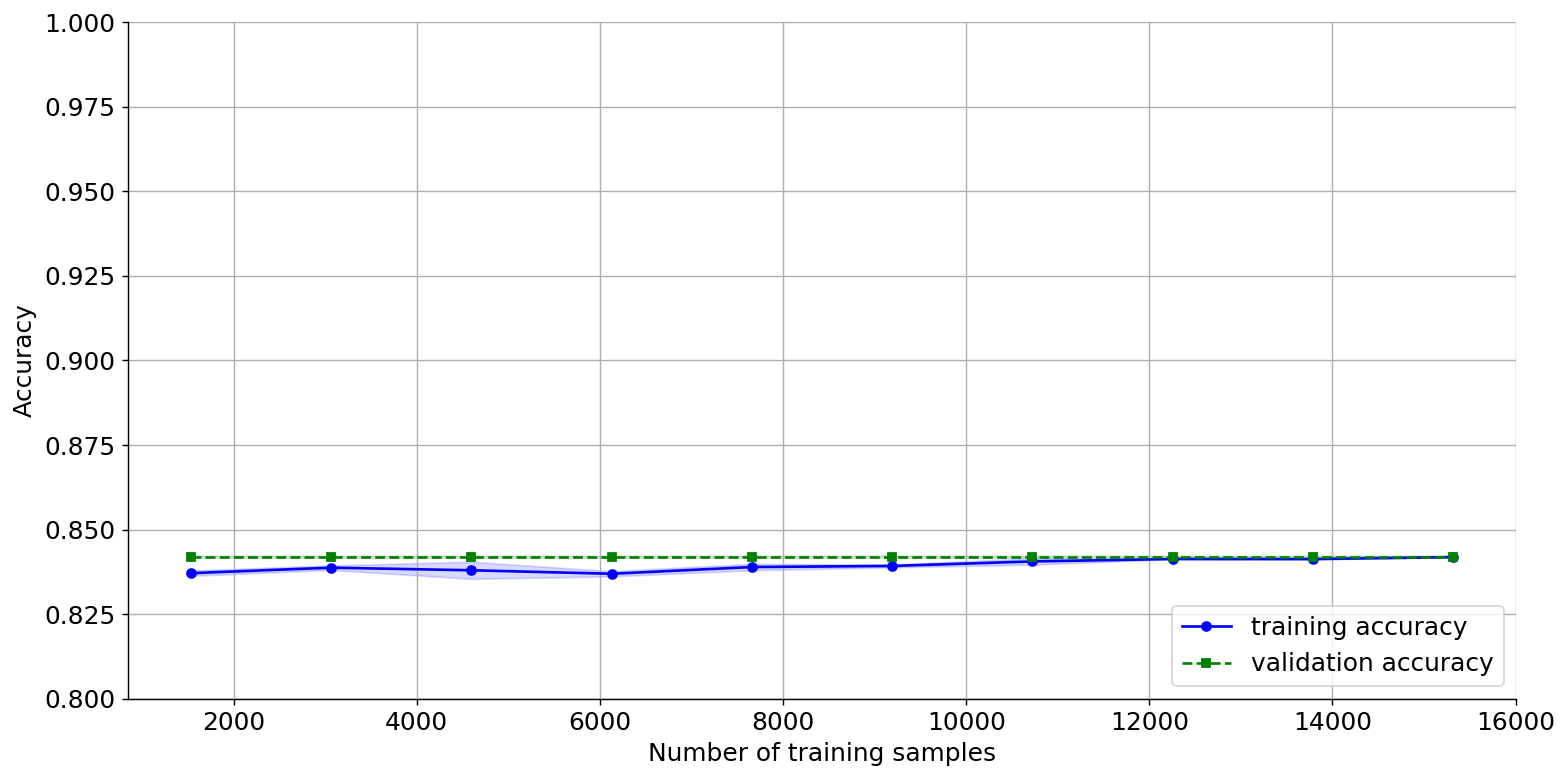

In [27]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svm,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import learning_curve

pipe_rf = make_pipeline(MultiColumnLabelEncoder(columns = category_column.columns),StandardScaler(),KernelPCA(n_components=7),RandomForestClassifier(n_estimators=10,random_state=1))

pipe_rf.fit(X_train, y_train)
rf_label = pipe_rf.predict(X_test)
print('Test Accuracy: %.3f' % pipe_rf.score(X_test, y_test))

Test Accuracy: 0.815


In [ ]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rf,
                                                        X=X_train,y=y_train,train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10,n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores, axis=1)      
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')               
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

In [ ]:
results=[]

for pl, tl, idx, chg in zip(y_pred, y_test, y_test.index, X.iloc[y_test.index]):
    if pl == tl:
        results.append([idx, chg, pl, tl, 1])
    else:
        results.append([idx, chg, pl, tl, 0])

In [ ]:
rf = pd.DataFrame(results, columns=['index', '$ chg', 'predicted', 'actual', 'correct'])
rf

In [ ]:
from sklearn import cross_validation
from sklearn.metrics import classification_report

scores = cross_validation.cross_val_score(pipe_lr, X, y, cv=5)
print("LogisticRegression cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print("LogisticRegression")
print(classification_report(y_test, y_pred))



scores = cross_validation.cross_val_score(pipe_rf, X, y, cv=5)
print("SGD cross_validation: {:.2f}".format(np.mean(scores, axis=0)))

print("SGD")
print(classification_report(y_test, rf_label))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# from sklearn import metrics

# # rescale data
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# rfc = RandomForestClassifier(n_estimators=500,random_state=1)
# rfc.fit(X_train_scaled, y_train)
# pred_forest = rfc.predict(X_test)

# print("Test score: {:.2f}".format(rfc.score(X_test_scaled, y_test)))


In [ ]:
feat_labels = X.columns[0:]
importances = rfc.feature_importances_

# reverse the list
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]],importances[indices[f]]))
    
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),importances[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [ ]:
# import pickle
# import os

# dest = os.path.join('movieclassifier', 'pkl_objects')
# if not os.path.exists(dest):
#     os.makedirs(dest)

# pickle.dump(stop,open(os.path.join(dest, 'stopwords.pkl'),'wb'),protocol=4)
# pickle.dump(clf,
            
from sklearn.externals import joblib
joblib.dump(pipe_rf, 'app/models/lrpipeline.pkl')

In [ ]:
model_columns = list(X.columns)
joblib.dump(model_columns, 'app/models/model_columns.pkl')

In [ ]:
clf = joblib.load('app/models/lrpipeline.pkl')
model_columns = joblib.load('app/models/model_columns.pkl')

In [ ]:
import json
my_json_string = json.dumps({
    "marketing_code": "A9301",
    "post code": "4012",
    "suburb": "Nundah",
    "state": "QLD",
    "enquired":"6/1/17 11:10",
    "property_use": "Refinance",
    "loan_reason": "Refinance",
    "loan amount": "230000"
})
my_json_string

In [ ]:
# test = pd.read_json(my_json_string, orient='index')
# data = pd.read_json(my_json_string, typ='series',orient='index')
# data = pd.DataFrame(data=data)
data = json.loads(my_json_string)
data = pd.DataFrame(data,index=[0])

In [ ]:
data = changeDateType(data)
data = getDetailDate(data)

In [ ]:
data.columns = data.columns.str.replace('_', ' ')
data = MultiColumnLabelEncoder(columns = category_column.columns).fit_transform(data)

In [ ]:
y_pred = pipe_rf.predict(data)
pipe_rf.predict_proba(data)

In [ ]:
y_pred

In [ ]:
clf = joblib.load('app/models/lrpipeline.pkl')

In [ ]:
prediction = clf.predict(data)

In [ ]:
prediction

In [ ]:
clf.predict_proba(data)